In [49]:
import pandas as pd
from pathlib import Path
import geopandas as gpd
import unicodedata
import re
from rapidfuzz import process, fuzz

In [50]:
BASE_PATH = Path(".")

def load_activity_df(folder_name, activity_label):
    dfs = []
    folder_path = BASE_PATH / folder_name

    for csv_file in folder_path.glob("*.csv"):
        df = pd.read_csv(csv_file)

        df["activity_type"] = activity_label
        df["source_file"] = csv_file.name

        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

enrolment_df = load_activity_df("api_data_aadhar_enrolment","enrolment")
demographic_df = load_activity_df("api_data_aadhar_demographic","demographic_update")
biometric_df = load_activity_df("api_data_aadhar_biometric", "biometric_update")

ka_enrolment_df = enrolment_df.loc[enrolment_df["state"] == "Karnataka"].copy()
ka_demographic_df = demographic_df.loc[demographic_df["state"] == "Karnataka"].copy()
ka_biometric_df = biometric_df.loc[biometric_df["state"] == "Karnataka"].copy()


In [51]:
ka_geo = gpd.read_file("mapKarnataka.json")
ka_geo

,dt_code,district,st_code,year,st_nm,geometry
0,558,Bidar,29,2011_c,Karnataka,"POLYGON ((77.44324 17.58428, 77.37872 17.58395..."
1,579,Kalaburagi,29,2011_c,Karnataka,"POLYGON ((76.68583 17.68221, 76.69443 17.66269..."
2,555,Belagavi,29,2011_c,Karnataka,"POLYGON ((75.34175 16.95603, 75.3358 16.86949,..."
3,580,Yadgir,29,2011_c,Karnataka,"POLYGON ((76.46149 16.71104, 76.47141 16.71169..."
4,556,Bagalkote,29,2011_c,Karnataka,"POLYGON ((75.45161 15.88628, 75.43804 15.89376..."
5,559,Raichur,29,2011_c,Karnataka,"POLYGON ((76.33211 16.19503, 76.33376 16.19569..."
6,560,Koppal,29,2011_c,Karnataka,"POLYGON ((75.84702 15.8391, 75.84702 15.8391, ..."
7,561,Gadag,29,2011_c,Karnataka,"POLYGON ((75.28947 15.69074, 75.27888 15.68846..."
8,565,Ballari,29,2011_c,Karnataka,"POLYGON ((76.81091 15.54759, 76.83473 15.56418..."
9,562,Dharwad,29,2011_c,Karnataka,"POLYGON ((74.7392 15.41419, 74.7296 15.43144, ..."


In [52]:
# normalize district names
def normalize_text(s):
    if pd.isna(s):
        return None
    s = unicodedata.normalize("NFKD", s)
    s = s.encode("ascii", "ignore").decode("utf-8")
    s = s.lower()
    # remove anything that's not a letter or space
    s = re.sub(r"[^a-z\s]", " ", s)
    s = s.replace("&", "and")
    s = " ".join(s.split())
    return s

for df in [ka_enrolment_df, ka_demographic_df, ka_biometric_df]:
    df.loc[:, "district_norm"] = df["district"].apply(normalize_text)
ka_geo["district_norm"] = ka_geo["district"].apply(normalize_text)

canonical_districts = ka_geo["district_norm"].unique().tolist()

In [53]:

all_districts = (
    pd.concat([
        ka_enrolment_df["district_norm"],
        ka_demographic_df["district_norm"],
        ka_biometric_df["district_norm"]
    ])
    .dropna()
    .unique()
)

# using rapidfuzz to match districts to geojson districts
def build_district_lookup(source_districts, target_districts, threshold=85):
    lookup = {}
    for d in source_districts:
        match, score, _ = process.extractOne(
            d,
            target_districts,
            scorer=fuzz.token_sort_ratio
        )
        lookup[d] = match if score >= threshold else None
    return lookup

district_lookup = build_district_lookup(
    all_districts,
    canonical_districts
)

for df in [ka_enrolment_df, ka_demographic_df, ka_biometric_df]:
    df["district_matched"] = df["district_norm"].map(district_lookup)

unmatched = [
    d for d, v in district_lookup.items() if v is None
]

unmatched

['bengaluru',
 'bangalore rural',
 'bangalore',
 'belgaum',
 'bellary',
 'bijapur',
 'chickmagalur',
 'gulbarga',
 'mysore',
 'shimoga',
 'vijayanagara',
 'bengaluru south',
 'bijapur kar']

In [54]:
# created manual map based on unmatched districts left out by rapidfuzz
manual_map = {
    "bangalore": "bengaluru urban",
    "bangalore rural": "bengaluru rural",
    "bengaluru": "bengaluru urban",
    "bengaluru south": "bengaluru urban",
    "belgaum": "belagavi",
    "bellary": "ballari",
    "bijapur": "vijayapura",
    "gulbarga": "kalaburagi",
    "mysore": "mysuru",
    "shimoga": "shivamogga",
    "chickmagalur": "chikmagalur",
    "bijapur kar":"vijayapura",
    "vijayanagara":"ballari",
}

district_lookup.update(manual_map)

for df in [ka_enrolment_df, ka_demographic_df, ka_biometric_df]:
    df.loc[:, "district_matched"] = df["district_norm"].map(district_lookup)

# False => no missing districts
any(df["district_matched"].isna().any()
    for df in [ka_enrolment_df, ka_demographic_df, ka_biometric_df])


False

In [55]:
# mega merge!
ka_enrolment_df.loc[:, "enrolment_total"] = (
    ka_enrolment_df["age_0_5"]
    + ka_enrolment_df["age_5_17"]
    + ka_enrolment_df["age_18_greater"]
)
ka_demographic_df.loc[:, "demographic_update_total"] = (
    ka_demographic_df["demo_age_5_17"]
    + ka_demographic_df["demo_age_17_"]
)
ka_biometric_df.loc[:, "biometric_update_total"] = (
    ka_biometric_df["bio_age_5_17"]
    + ka_biometric_df["bio_age_17_"]
)

district_enrolment = (
    ka_enrolment_df
    .groupby("district_matched", as_index=False)["enrolment_total"]
    .sum()
)
district_demo = (
    ka_demographic_df
    .groupby("district_matched", as_index=False)["demographic_update_total"]
    .sum()
)
district_bio = (
    ka_biometric_df
    .groupby("district_matched", as_index=False)["biometric_update_total"]
    .sum()
)
district_wide = (
    district_enrolment
    .merge(district_demo, on="district_matched", how="left")
    .merge(district_bio, on="district_matched", how="left")
    .fillna(0)
)

district_wide


,district_matched,enrolment_total,demographic_update_total,biometric_update_total
0,bagalkote,7391,53857,78859
1,ballari,9120,66471,125555
2,belagavi,14548,117343,190070
3,bengaluru rural,5434,48313,38045
4,bengaluru urban,61273,359480,496200
5,bidar,4920,43059,79708
6,chamarajanagara,2879,18313,33124
7,chikkaballapura,3152,36221,41933
8,chikkamagaluru,1305,11801,16561
9,chikmagalur,1231,10484,21919


In [ ]:
# calculating cols useful for factor calculations
district_wide.loc[:, "total_updates"] = (
    district_wide["demographic_update_total"]
    + district_wide["biometric_update_total"]
)

district_wide.loc[:, "total_activity"] = (
    district_wide["enrolment_total"]
    + district_wide["total_updates"]
)

# update pressure dists
district_wide["update_pressure"] = (
    district_wide["total_updates"]
    / district_wide["enrolment_total"]
)

district_wide["biometric_infra_intensity"] = (
    district_wide["biometric_update_total"]
    / district_wide["total_updates"]
)

district_wide["total_activity"] = (
    district_wide["enrolment_total"]
    + district_wide["total_updates"]
)

# total aadhaar activity districtwise
district_wide.sort_values(ascending=False, by="total_activity").head(5)

,district_matched,enrolment_total,demographic_update_total,biometric_update_total,total_updates,total_activity,update_pressure,biometric_infra_intensity
4,bengaluru urban,61273,359480,496200,855680,916953,13.965042,0.579890
2,belagavi,14548,117343,190070,307413,321961,21.130946,0.618289
17,kalaburagi,9138,63919,134602,198521,207659,21.724776,0.678024
1,ballari,9120,66471,125555,192026,201146,21.055482,0.653844
29,vijayapura,9830,62354,108215,170569,180399,17.351882,0.634435


(np.float64(73.8606819548392),
 np.float64(78.81081494837701),
 np.float64(11.251600983415749),
 np.float64(18.797249348269293))

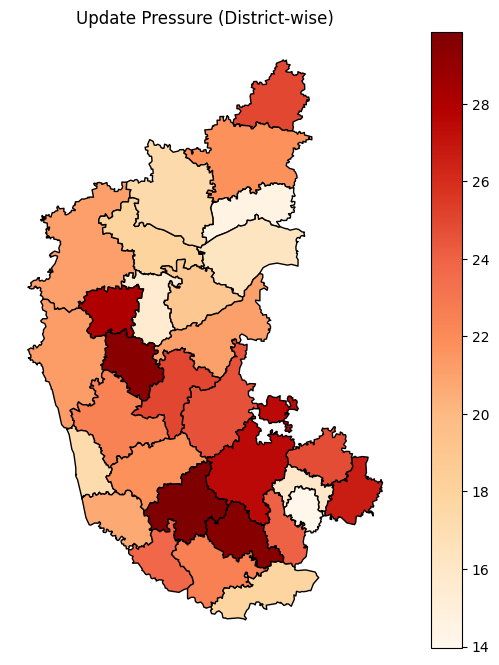

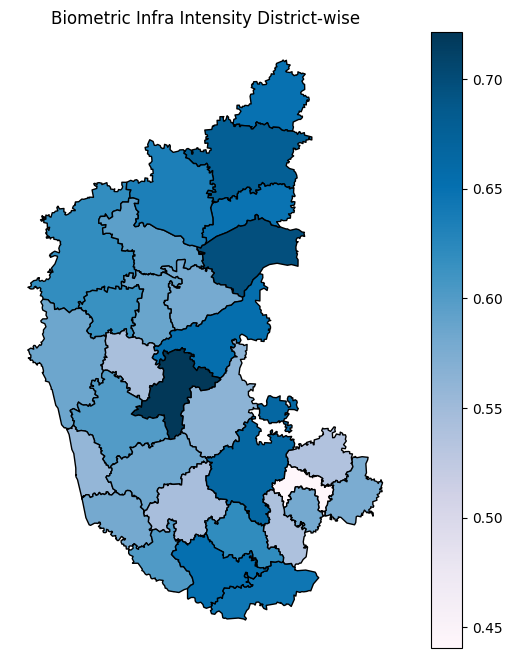

In [66]:
ka_geo_metrics = ka_geo.merge(
    district_wide,
    left_on="district_norm",
    right_on="district_matched",
    how="left"
)

ax1 = ka_geo_metrics.plot(
    column="update_pressure",
    cmap="OrRd",
    legend=True,
    edgecolor="black",
    figsize=(8, 8)
)
ax1.set_title("Update Pressure (District-wise)")
ax1.axis("off")

ax2 = ka_geo_metrics.plot(
    column="biometric_infra_intensity",
    cmap="PuBu",
    legend=True,
    edgecolor="black",
    figsize=(8, 8)
)
ax2.set_title("Biometric Infra Intensity District-wise")
ax2.axis("off")


In [ ]:
# no outlier!

q1 = district_wide["update_pressure"].quantile(0.25)
q3 = district_wide["update_pressure"].quantile(0.75)
iqr = q3 - q1

district_wide["high_pressure_outlier"] = (
    district_wide["update_pressure"] > (q3 + 1.5 * iqr)
)
district_wide[district_wide["high_pressure_outlier"]]


,district_matched,enrolment_total,demographic_update_total,biometric_update_total,total_updates,total_activity,update_pressure,biometric_infra_intensity,high_pressure_outlier
